<h1><center>Проведение EDA. Практика</center></h1>

Вернёмся к задаче оттока для компании «Космолайн», которую вы решали в предыдущих темах. После каждого пройденного урока вам нужно понемногу улучшать свой пайплайн и с точки зрения качества модели, и с точки зрения скорости работы в продакшене. 

Начнём с проведения разведочного анализа данных, или EDA.

Для начала определите среду выполнения анализа и задайте глобальные переменные, которые понадобятся вам в ходе решения задач. Название эксперимента можете взять из предыдущих уроков. Переменная ASSETS_DIR хранит название директории, где, в свою очередь, хранятся артефакты, полученные в ходе первичного анализа данных. А ещё, проводя EDA, вы можете увеличить стандартное значение отображаемых колонок и строк, а также установить стили графиков — зачастую это полезно.

In [2]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "clean_users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "ex_visulisation_1" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

Затем загрузите данные для обучения модели, как вы это делали в предыдущих уроках.

In [3]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {"host": 'rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net', #os.getenv("DB_DESTINATION_HOST"),
                        "port": '6432', #os.getenv("DB_DESTINATION_PORT"),
                        "dbname": 'playground_mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_NAME"),
                        "user": 'mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_USER"),
                        "password": '0c567edd8ad8472e87d5c85cc4d664e4' } #os.getenv("DB_DESTINATION_PASSWORD")}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)
df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,None
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,None


Задание 1

Постройте графики количества уникальных пользователей (customer_id), распределённых по таким группам:
- пользователи по различным type,
- пользователи по различным payment_method,
- пользователи по различным internet_service,
- пользователи по различным gender.


Создайте одну фигуру размером 16.5x12.5 с четырьмя графиками по списку выше. Сохраните вашу картинку в директорию ASSETS_DIR, а файл назовите cat_features_1.

/tmp/ipykernel_2387/2889844888.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);


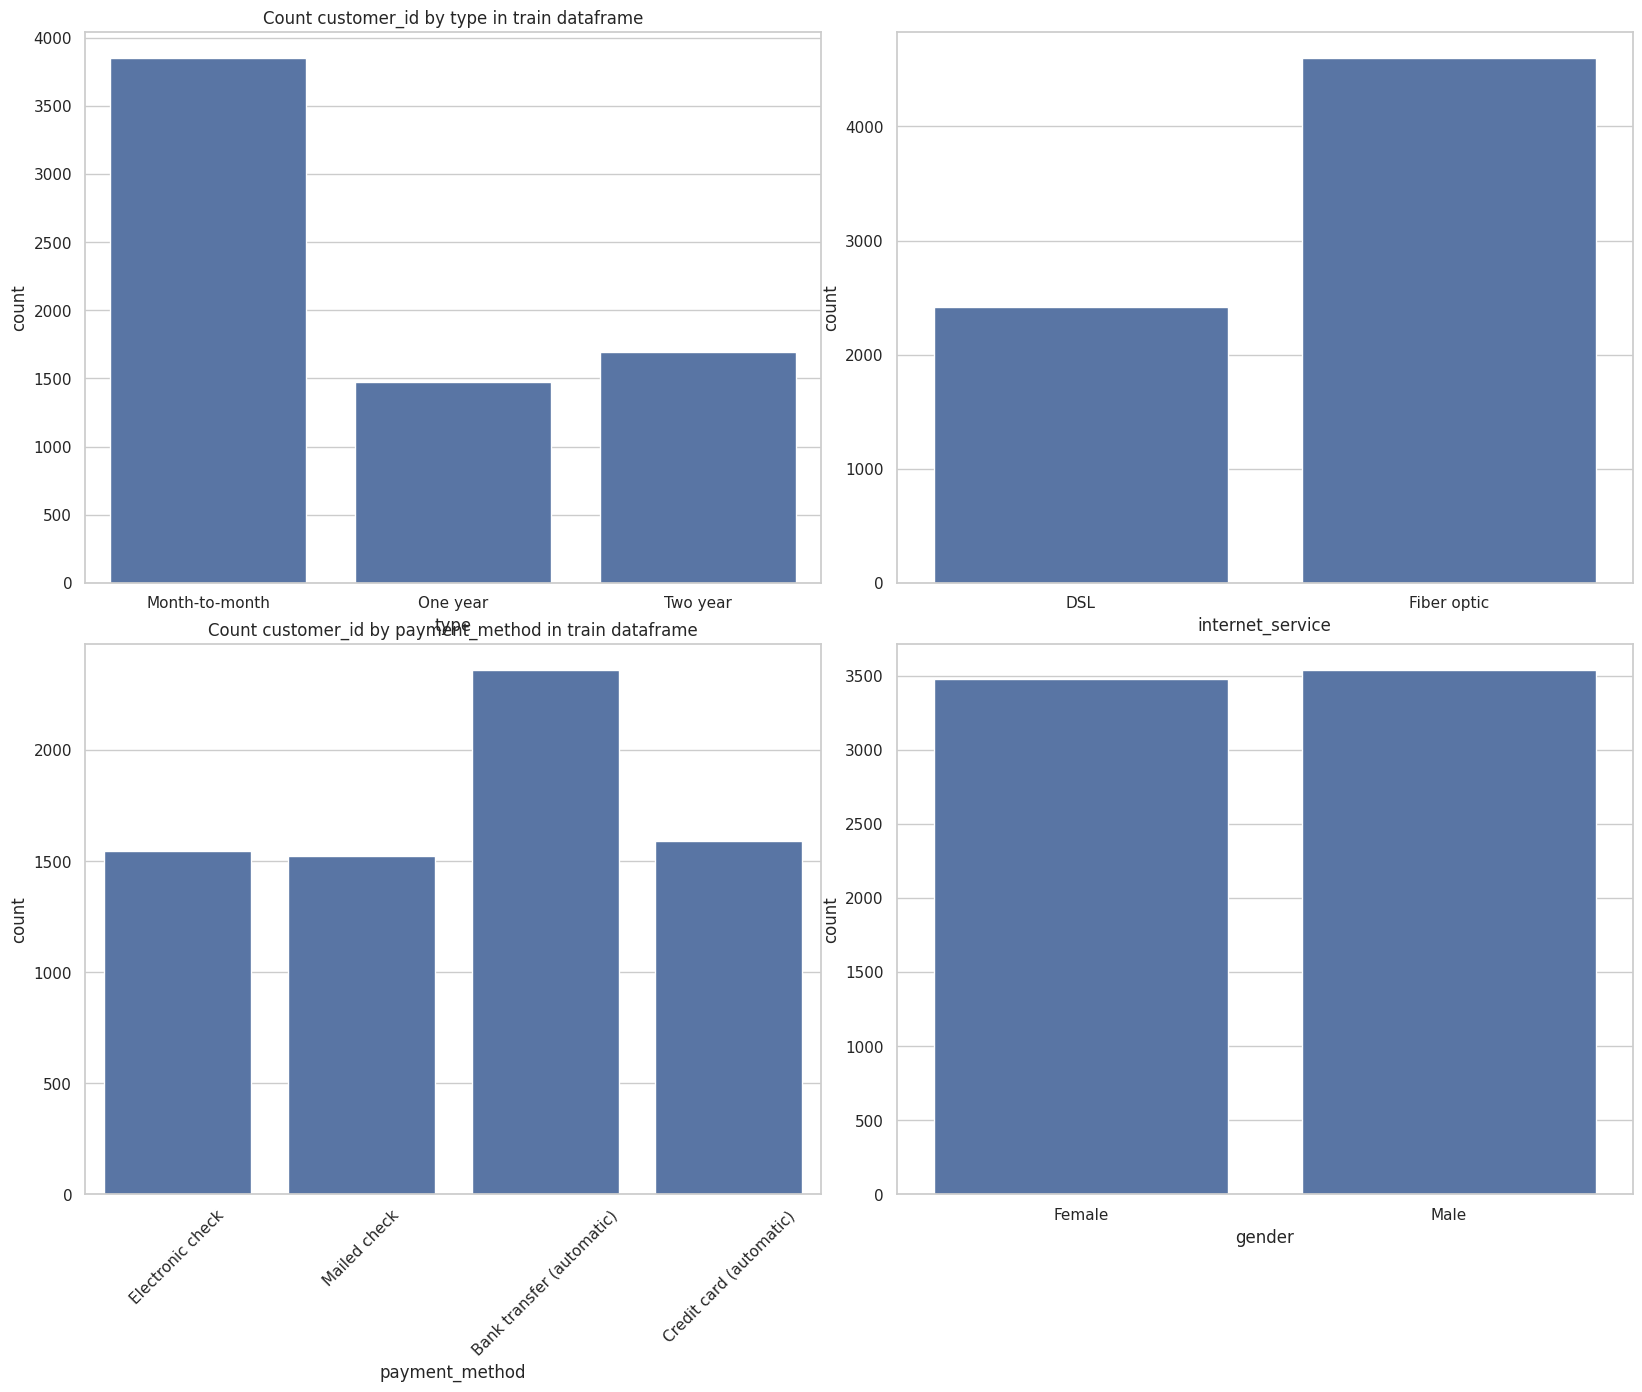

In [4]:
fig, axs = plt.subplots(2, 2)# ваш код тут #
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index() # ваш код тут #
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[0, 0]) # ваш код тут #
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
# ваш код тут #
agg_df = df.groupby(x)[y].agg(['count']).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = df.groupby(x)[y].agg(stat).reset_index()  # Группировка данных
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[0, 1])  # Построение графика

x = "gender"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = df.groupby(x)[y].agg(stat).reset_index()  # Группировка данных
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[1, 1])  # Построение графика

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

Карта бинарных признаков:

In [ ]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count'] # ваш код здесь

binarnaya = df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False)

Хитмеп для бинарных признаков:

heat_df = df[binary_columns].apply(pd.Series.value_counts).T # ваш код здесь #)
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))